In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
#import Libraries
import findspark
findspark.init('./spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import pyspark.sql.functions as F

In [4]:
import time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [5]:
# sc = SparkContext()
conf = SparkConf().setAppName("pySparkAnalysis1").setMaster("local")
sc = SparkContext.getOrCreate(conf=conf)

##CREATING "SPARKSESSION" from existing "SPARKCONTEXT"
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier

In [7]:
# To load it from file, run:
pickleRdd = sc.pickleFile('./df1.clean').collect()
df2 = spark.createDataFrame(pickleRdd)
df2.show(2)
print(df2.count())

+------+---+-----------+------------+--------+----------+--------+---+-------+-------------+------------+---------------+--------+----------------------+-----------------+
|gender|age|scholarship|hypertension|diabetes|alcoholism|handicap|sms|no_show|schedule_hour|schedule_day|appointment_day|day_diff|precedent_appointments|precedent_noshows|
+------+---+-----------+------------+--------+----------+--------+---+-------+-------------+------------+---------------+--------+----------------------+-----------------+
|     1|  2|          1|           0|       0|         0|       0|  1|      1|            7|          29|              5|      37|                     1|                0|
|     1| 46|          0|           1|       0|         0|       0|  1|      0|           10|          25|             31|       6|                     0|                0|
+------+---+-----------+------------+--------+----------+--------+---+-------+-------------+------------+---------------+--------+----------

In [8]:
df2.columns

['gender',
 'age',
 'scholarship',
 'hypertension',
 'diabetes',
 'alcoholism',
 'handicap',
 'sms',
 'no_show',
 'schedule_hour',
 'schedule_day',
 'appointment_day',
 'day_diff',
 'precedent_appointments',
 'precedent_noshows']

In [9]:
# Change the number of max_seq_items shown by configuring the pandas options
#　Avoid any content being truncated in the output cell. 
# pd.options.display.max_rows = 5000

for c in df2.columns:
    print(c)
    print( df2.groupby("no_show").agg(F.count(c).alias('count'), F.mean(c).alias('mean'), F.stddev(c).alias('std'), 
                                      F.min(c).alias('min'), F.expr("percentile("+c+", array(0.25))")[0].alias('%25'),
                                      F.expr("percentile("+c+", array(0.5))")[0].alias('%50'),
                                      F.expr("percentile("+c+", array(0.75))")[0].alias('%75'),F.max(c).alias('max')).show())

gender
+-------+-----+------------------+-------------------+---+---+---+---+---+
|no_show|count|              mean|                std|min|%25|%50|%75|max|
+-------+-----+------------------+-------------------+---+---+---+---+---+
|      0|49653| 0.643183694842205| 0.4790647677193682|  0|0.0|1.0|1.0|  1|
|      1|12091|0.6423786287321148|0.47931965075111166|  0|0.0|1.0|1.0|  1|
+-------+-----+------------------+-------------------+---+---+---+---+---+

None
age
+-------+-----+-----------------+------------------+---+----+----+----+---+
|no_show|count|             mean|               std|min| %25| %50| %75|max|
+-------+-----+-----------------+------------------+---+----+----+----+---+
|      0|49653|37.39979457434596|23.825661419294907|  0|17.0|38.0|57.0|115|
|      1|12091|33.82623438921512|22.074428424700667|  0|16.0|32.0|51.0|115|
+-------+-----+-----------------+------------------+---+----+----+----+---+

None
scholarship
+-------+-----+-------------------+------------------+---+-

+-------+-----+
|no_show|count|
+-------+-----+
|      1|12091|
|      0|49653|
+-------+-----+

None


array([1, 0, 0, ..., 0, 0, 0])

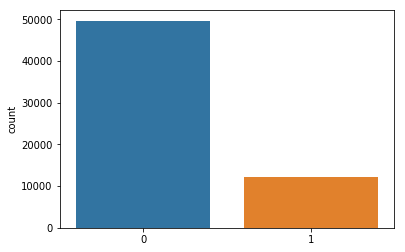

In [10]:
## DATA EXPLORATION & ANALYSIS
#about 20% of patients won't show up

summary9 = df2.groupBy('no_show').count().orderBy('count').show()
print(summary9)

np.array(df2.select('no_show').collect()).flatten()

sns.countplot(np.array(df2.select('no_show').collect()).flatten())

In [11]:
## WEIGHT OF EVIDENCE (WoE) & INFORMATION VALUE (IV)
# Create df3 for checking WoE and IV as reference 
df3 = df2

In [12]:
from pyspark.sql.types import DoubleType
df3 = df3.withColumn("age", df3.age.cast(DoubleType()))
df3 = df3.withColumn("schedule_hour", df3.schedule_hour.cast(DoubleType()))
df3 = df3.withColumn("schedule_day", df3.schedule_day.cast(DoubleType()))
df3 = df3.withColumn("appointment_day", df3.appointment_day.cast(DoubleType()))
df3 = df3.withColumn("schedule_day", df3.schedule_day.cast(DoubleType()))
df3 = df3.withColumn("day_diff", df3.day_diff.cast(DoubleType()))
df3 = df3.withColumn("precedent_appointments", df3.precedent_appointments.cast(DoubleType()))


In [13]:
# values = [(0.1,), (0.4,), (1.2,), (1.5,)]
# df = spark.createDataFrame(values, ["values"])

from pyspark.ml.feature import QuantileDiscretizer
df3 = QuantileDiscretizer(numBuckets=10, inputCol="age",outputCol="age_bins").fit(df3).transform(df3)
df3 = QuantileDiscretizer(numBuckets=3, inputCol="schedule_hour",outputCol="schedule_hour_bins").fit(df3).transform(df3)
df3 = QuantileDiscretizer(numBuckets=4, inputCol="schedule_day",outputCol="schedule_day_bins").fit(df3).transform(df3)
df3 = QuantileDiscretizer(numBuckets=4, inputCol="appointment_day",outputCol="appointment_day_bins").fit(df3).transform(df3)
df3 = QuantileDiscretizer(numBuckets=5, inputCol="day_diff",outputCol="day_diff_bins").fit(df3).transform(df3)
df3 = QuantileDiscretizer(numBuckets=4, inputCol="precedent_appointments",outputCol="precedent_appointments_bins").fit(df3).transform(df3)
df3.show(5)

+------+----+-----------+------------+--------+----------+--------+---+-------+-------------+------------+---------------+--------+----------------------+-----------------+--------+------------------+-----------------+--------------------+-------------+---------------------------+
|gender| age|scholarship|hypertension|diabetes|alcoholism|handicap|sms|no_show|schedule_hour|schedule_day|appointment_day|day_diff|precedent_appointments|precedent_noshows|age_bins|schedule_hour_bins|schedule_day_bins|appointment_day_bins|day_diff_bins|precedent_appointments_bins|
+------+----+-----------+------------+--------+----------+--------+---+-------+-------------+------------+---------------+--------+----------------------+-----------------+--------+------------------+-----------------+--------------------+-------------+---------------------------+
|     1| 2.0|          1|           0|       0|         0|       0|  1|      1|          7.0|        29.0|            5.0|    37.0|                   1.0|

In [14]:
# Define function to calculate WoE & IV
def calculate_woe_iv(dataset, feature, target):    
    lst = []
    for i in range(dataset.select(feature).distinct().count()):
        
        val = dataset.select(feature).distinct().rdd.flatMap(lambda x: x).collect()[i-1]
        
        cond1 = df3[feature] == val 
        cond2 = df3['no_show'] == 0
        cond3 = df3['no_show'] == 1

        lst.append({
            'Value': val,        
            'All': dataset.filter(dataset[feature] == val).count(),            
            'Show': dataset.filter(cond1 & cond2 ).count(),
            'No_show': dataset.filter(cond1 & cond3 ).count(),
        })
        
    dfset = pd.DataFrame(lst)
    dfset['Distr_show'] = dfset['Show'] / dfset['Show'].sum()
    dfset['Distr_no_show'] = dfset['No_show'] / dfset['No_show'].sum()
    dfset['WoE'] = np.log(dfset['Distr_show'] / dfset['Distr_no_show'])
    dfset = dfset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dfset['IV'] = (dfset['Distr_show'] - dfset['Distr_no_show']) * dfset['WoE']
    iv = dfset['IV'].sum()
    
    dfset = dfset.sort_values(by='WoE')
    

    return dfset, iv

In [15]:
### This chunk was commented out owing to very long run time. ###

# Calculate WoE & IV for each variables

#for col in df3.columns:
#    if col == 'no_show': continue
#    else:
#        print('WoE & IV for column: {}'.format(col))
#        df3_woe_iv, iv = calculate_woe_iv(df3, col, 'no_show')
#        print(df3_woe_iv)
#        print('IV score: {:.2f}'.format(iv))
#        print('\n')

WoE & IV for column: gender
     All  No_show   Show  Value  Distr_show  Distr_no_show       WoE        IV
1  22041     4324  17717      0    0.356816       0.357621 -0.002254  0.000002
0  39703     7767  31936      1    0.643184       0.642379  0.001252  0.000001
IV score: 0.00


WoE & IV for column: age
      All  No_show  Show  Value  Distr_show  Distr_no_show       WoE        IV
72      2        1     1  115.0    0.000020       0.000083 -1.412597  0.000088
51    761      206   555   22.0    0.011178       0.017037 -0.421505  0.002470
89    713      184   529   24.0    0.010654       0.015218 -0.356545  0.001627
0      39       10    29   91.0    0.000584       0.000827 -0.347887  0.000085
95    738      189   549    9.0    0.011057       0.015631 -0.346246  0.001584
76    651      165   486   13.0    0.009788       0.013647 -0.332334  0.001282
9       4        1     3   98.0    0.000060       0.000083 -0.313985  0.000007
68    829      207   622   17.0    0.012527       0.017120 -0

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


       All  No_show   Show  Value  Distr_show  Distr_no_show       WoE  \
34       7        5      2  104.0    0.000040       0.000414 -2.328888   
14       7        4      3  155.0    0.000060       0.000331 -1.700280   
50      17        8      9   79.0    0.000181       0.000662 -1.294814   
114     72       33     39   55.0    0.000785       0.002729 -1.245543   
29      12        5      7   80.0    0.000141       0.000414 -1.076125   
39     399      165    234   25.0    0.004713       0.013647 -1.063222   
92      27       11     16   73.0    0.000322       0.000910 -1.037904   
120     45       18     27   54.0    0.000544       0.001489 -1.007132   
112     10        4      6   89.0    0.000121       0.000331 -1.007132   
94     167       66    101   40.0    0.002034       0.005459 -0.987132   
51      94       37     57   45.0    0.001148       0.003060 -0.980464   
78      67       26     41   59.0    0.000826       0.002150 -0.957122   
49      21        8     13   78.0    0

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


      All  No_show   Show  Value  Distr_show  Distr_no_show       WoE  \
8       5        2      3   18.0    0.000060       0.000165 -1.007132   
34     22        7     15   13.0    0.000302       0.000579 -0.650457   
26     10        3      7   19.0    0.000141       0.000248 -0.565300   
40     11        3      8   15.0    0.000161       0.000248 -0.431768   
4     212       48    164    7.0    0.003303       0.003970 -0.183932   
1     105       23     82    8.0    0.001651       0.001902 -0.141372   
36    313       67    246    6.0    0.004954       0.005541 -0.111959   
21     38        8     30   11.0    0.000604       0.000662 -0.090842   
25   2422      509   1913    3.0    0.038527       0.042097 -0.088617   
39    564      118    446    5.0    0.008982       0.009759 -0.082963   
9   13848     2894  10954    1.0    0.220611       0.239352 -0.081532   
30   5541     1150   4391    2.0    0.088434       0.095112 -0.072802   
41     84       17     67    9.0    0.001349       

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


      All  No_show   Show  Value  Distr_show  Distr_no_show       WoE  \
2       9        7      2      7    0.000040       0.000579 -2.665360   
6      33       23     10      5    0.000201       0.001902 -2.245507   
7    2441     1634    807      1    0.016253       0.135142 -2.118060   
13    520      328    192      2    0.003867       0.027128 -1.948116   
9     164       94     70      3    0.001410       0.007774 -1.707397   
14     59       31     28      4    0.000564       0.002564 -1.514380   
8       4        2      2     10    0.000040       0.000165 -1.412597   
4       4        2      2      9    0.000040       0.000165 -1.412597   
3      13        5      8      6    0.000161       0.000414 -0.942594   
12      1        0      1     11    0.000020       0.000000  0.000000   
11      3        3      0      8    0.000000       0.000248  0.000000   
0       1        1      0     15    0.000000       0.000083  0.000000   
15      1        1      0     13    0.000000       

In [15]:
df3.select('day_diff_bins', 'day_diff').show(3)

+-------------+--------+
|day_diff_bins|day_diff|
+-------------+--------+
|          4.0|    37.0|
|          2.0|     6.0|
|          4.0|    21.0|
+-------------+--------+
only showing top 3 rows



In [16]:
drop_list =  ['age', 'schedule_hour', 'schedule_day', 'appointment_day','day_diff', 'precedent_appointments']
df3 = df3.drop(*drop_list)
df3.show(3)

+------+-----------+------------+--------+----------+--------+---+-------+-----------------+--------+------------------+-----------------+--------------------+-------------+---------------------------+
|gender|scholarship|hypertension|diabetes|alcoholism|handicap|sms|no_show|precedent_noshows|age_bins|schedule_hour_bins|schedule_day_bins|appointment_day_bins|day_diff_bins|precedent_appointments_bins|
+------+-----------+------------+--------+----------+--------+---+-------+-----------------+--------+------------------+-----------------+--------------------+-------------+---------------------------+
|     1|          1|           0|       0|         0|       0|  1|      1|                0|     0.0|               0.0|              3.0|                 1.0|          4.0|                        2.0|
|     1|          0|           1|       0|         0|       0|  1|      0|                0|     6.0|               1.0|              3.0|                 3.0|          2.0|                   

In [18]:
# Create df for the relevant variables
#df4 = df2.select('hypertension', 'sms', 'precedent_noshows', 'age', 'schedule_hour',  
#           'schedule_day', 'appointment_day', 'day_diff', 'precedent_appointments', 'no_show')

# Create df for the relevant variables - Top 6 reiteration
df4 = df2.select('sms', 'precedent_noshows', 'age', 'schedule_day', 'day_diff', 'no_show')

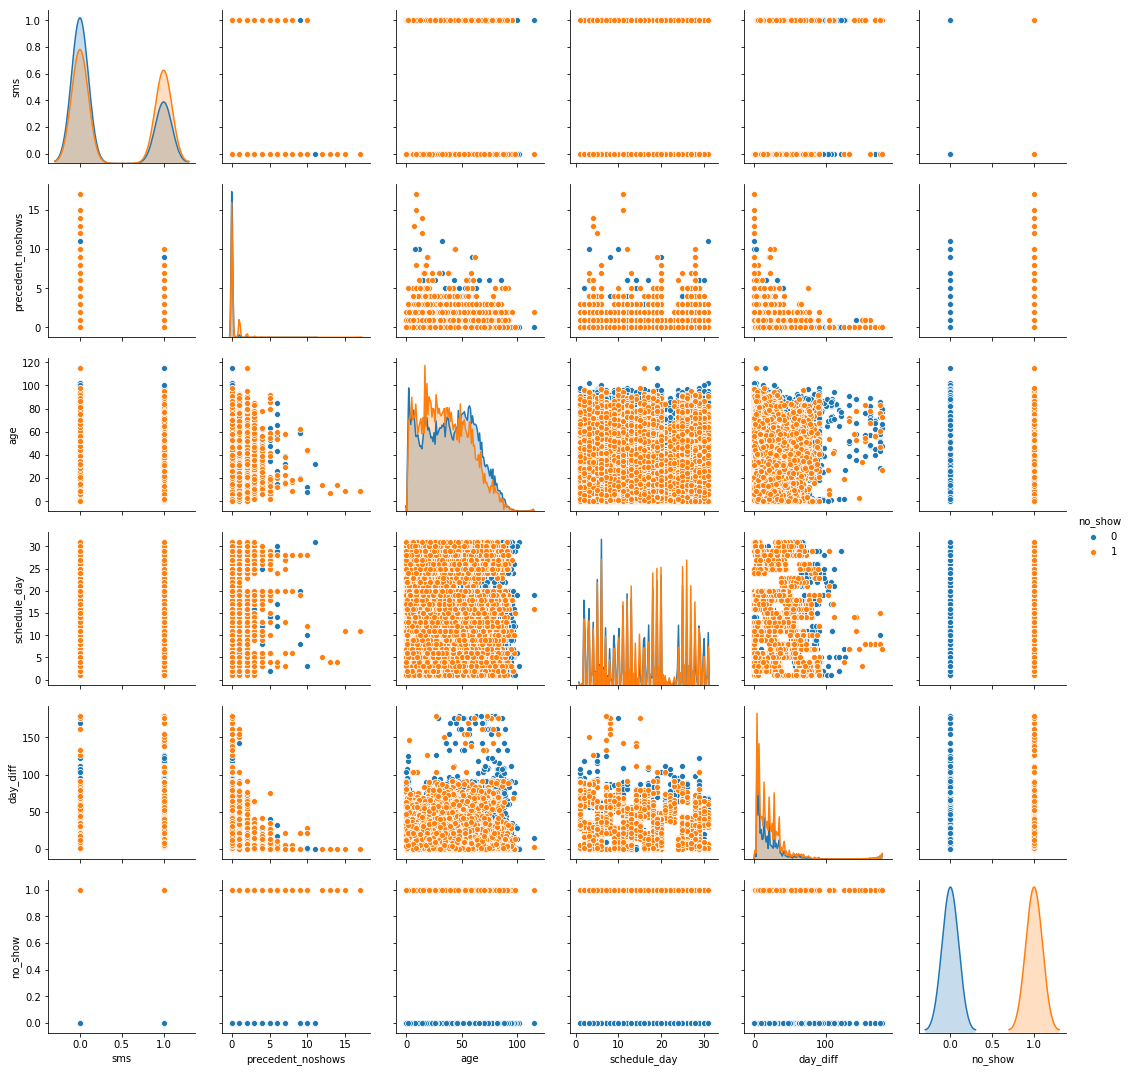

In [19]:
# Pairplots for the relevant variables
# sns.pairplot(np.array(df4.select(df4.columns[:]).collect()).flatten(), hue='no_show')
sns.pairplot(df4.toPandas(), hue='no_show', diag_kws={'bw': 0.1})

In [20]:
from pyspark.mllib.stat import Statistics

summary11 = df4
col_names = summary11.columns
features = summary11.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print(corr_df.to_string())

                        sms  precedent_noshows       age  schedule_day  day_diff   no_show
sms                1.000000           0.019559  0.020690      0.158839  0.399269  0.129519
precedent_noshows  0.019559           1.000000 -0.020087      0.026523  0.007279  0.209376
age                0.020690          -0.020087  1.000000     -0.015877  0.048574 -0.060254
schedule_day       0.158839           0.026523 -0.015877      1.000000  0.013781  0.043362
day_diff           0.399269           0.007279  0.048574      0.013781  1.000000  0.185775
no_show            0.129519           0.209376 -0.060254      0.043362  0.185775  1.000000


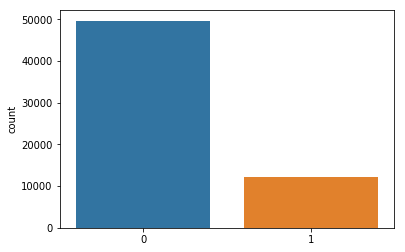

In [21]:
# Plot to show the data imbalanced data
# Almost 4 times more 'No' == 0 instances than 'Yes' == 1 instances
sns.countplot(np.array(df4.select('no_show').collect()).flatten())

In [22]:
# df4.columns
# 'hypertension', 'sms', 'precedent_noshows', 'age', 'schedule_hour', 'schedule_day', 'appointment_day', 'day_diff','precedent_appointments', 'no_show'

df4 = df4.withColumnRenamed('no_show', 'label')
df4.columns
print(df4.count())

['sms', 'precedent_noshows', 'age', 'schedule_day', 'day_diff', 'label']

61744


In [23]:
# Import the necessary class
from pyspark.ml.feature import VectorAssembler

# Merge the predictors columns into a single column.
#assembler = VectorAssembler(inputCols=[
#    'hypertension', 'sms', 'precedent_noshows', 'age', 'schedule_hour', 'schedule_day', 'appointment_day', 
#    'day_diff','precedent_appointments'], outputCol='features')

# Create an assembler object to merge the predictors columns into a single column - for reiteration
assembler = VectorAssembler(inputCols=['sms', 'precedent_noshows', 'age', 'schedule_day', 'day_diff'], 
outputCol='features')

# Consolidate predictor columns
df4_assembled = assembler.transform(df4)

# Check the resulting column
df4_assembled.select('features', 'label').show(5, truncate=False)

+------------------------+-----+
|features                |label|
+------------------------+-----+
|[1.0,0.0,2.0,29.0,37.0] |1    |
|[1.0,0.0,46.0,25.0,6.0] |0    |
|[1.0,0.0,53.0,15.0,21.0]|0    |
|[0.0,0.0,56.0,11.0,22.0]|0    |
|(5,[2,3],[21.0,30.0])   |0    |
+------------------------+-----+
only showing top 5 rows



In [24]:
## Oversampling 
df_a = df4_assembled.filter(df4_assembled['label'] == 0)
df_b = df4_assembled.filter(df4_assembled['label'] == 1)

a_count = df_a.count()
b_count = df_b.count() 
print("Label 0 count : ", a_count)
print("Label 1 count : ", b_count)
ratio = a_count / b_count

df_b_oversampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
df_oversample = df_a.unionAll(df_b_oversampled)
print("oversamplpe ,Label 0 count :", df_oversample.filter(df_oversample['label'] == 0).count())
print("oversamplpe ,Label 1 count :", df_oversample.filter(df_oversample['label'] == 1).count())

Label 0 count :  49653
Label 1 count :  12091
oversamplpe ,Label 0 count : 49653
oversamplpe ,Label 1 count : 49610


In [25]:
## Weight OVERSAMPLED
df_oversample.show(3)
# Randomly split the df4 data into two sets with 80:20 proportions. 
# For repeatability set a random number seed of 17 for the spli
X, y = df_oversample.randomSplit([0.8,0.2], seed=17)

print(X.count() )
print(y.count() )
print(df_oversample.count())

# Check that the testing data has roughly 80% of the records from the original data.
training_ratio = X.count() / df_oversample.count()
print(training_ratio)

+---+-----------------+---+------------+--------+-----+--------------------+
|sms|precedent_noshows|age|schedule_day|day_diff|label|            features|
+---+-----------------+---+------------+--------+-----+--------------------+
|  1|                0| 46|          25|       6|    0|[1.0,0.0,46.0,25....|
|  1|                0| 53|          15|      21|    0|[1.0,0.0,53.0,15....|
|  0|                0| 56|          11|      22|    0|[0.0,0.0,56.0,11....|
+---+-----------------+---+------------+--------+-----+--------------------+
only showing top 3 rows

79290
19973
99263
0.7987870606368939


In [26]:
# Overview the training set 'X' and testing set'y' 
print(X.show(3))
print(y.show(3))
# sum(y_train == 0)
# sum(y_train == 1)

y.where(y.label == 0).count()
y.where(y.label == 1).count()

+---+-----------------+---+------------+--------+-----+-------------+
|sms|precedent_noshows|age|schedule_day|day_diff|label|     features|
+---+-----------------+---+------------+--------+-----+-------------+
|  0|                0|  0|           1|       0|    0|(5,[3],[1.0])|
|  0|                0|  0|           1|       0|    0|(5,[3],[1.0])|
|  0|                0|  0|           1|       0|    0|(5,[3],[1.0])|
+---+-----------------+---+------------+--------+-----+-------------+
only showing top 3 rows

None
+---+-----------------+---+------------+--------+-----+-------------+
|sms|precedent_noshows|age|schedule_day|day_diff|label|     features|
+---+-----------------+---+------------+--------+-----+-------------+
|  0|                0|  0|           1|       0|    0|(5,[3],[1.0])|
|  0|                0|  0|           2|       0|    0|(5,[3],[2.0])|
|  0|                0|  0|           2|       0|    0|(5,[3],[2.0])|
+---+-----------------+---+------------+--------+-----+-----

10011

9962

In [27]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1849|
|    0|       1.0| 4006|
|    0|       0.0| 6005|
|    1|       1.0| 8113|
+-----+----------+-----+

None
0.7068542532418766
0.6694446736529417
0.814394699859466


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ROC - Decision Tree Classifier')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

'00:01:17'

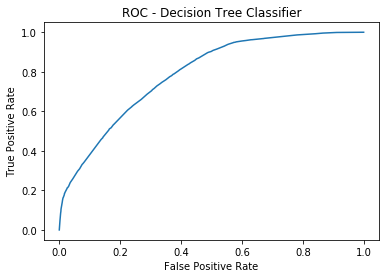

In [28]:
## Decision Tree k-fold cross validation

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

start_time = time.time()

dtc = DecisionTreeClassifier() 

paramGriddt = ParamGridBuilder()\
  .addGrid(dtc.maxDepth, [10])\
  .build()
#.addGrid(dtc.impurity, ['gini']) \

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')

# // define cross validation stage to search through the parameters
# // K-Fold cross validation with BinaryClassificationEvaluator
cvdtc = CrossValidator()\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGriddt)\
  .setNumFolds(5)\
  .setEstimator(dtc)

# // fit will run cross validation and choose the best set of parameters
cvdtcModel = cvdtc.fit(X)

# // test cross validated model with test data
cvPredictiondtc = cvdtcModel.transform(y)
print(cvPredictiondtc.groupBy("label", "prediction").count().show())
accdtc = evaluator.evaluate(cvPredictiondtc)
#print(accdtc)

# Calculate the elements of the confusion matrix
#Count the number of True Negatives, True Positives, False Negatives and False Positives.
TNdtc = cvPredictiondtc.filter('prediction = 0 AND label = prediction').count()
TPdtc = cvPredictiondtc.filter('prediction =1 AND label = prediction').count()
FNdtc = cvPredictiondtc.filter('prediction = 0 AND label != prediction').count()
FPdtc = cvPredictiondtc.filter('prediction = 1 AND label != prediction').count()
 
# Accuracy measures the proportion of correct predictions
accuracy_dtc = (TNdtc+TPdtc)/(TNdtc+TPdtc+FNdtc+FPdtc)
precision_dtc = TPdtc/(TPdtc+FPdtc)
recall_dtc = TPdtc/(TPdtc+FNdtc)
f1score_dtc = 2* ( (precision_dtc*recall_dtc)/(precision_dtc+recall_dtc) )

print(accuracy_dtc)
print(precision_dtc)
print(recall_dtc)

import matplotlib.pyplot as plt

preds_dtc = cvPredictiondtc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                               float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points_dtc = CurveMetrics(preds_dtc).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points_dtc]
y_val = [x[1] for x in points_dtc]
plt.title("ROC - Decision Tree Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 4511|
|    0|       1.0| 2725|
|    0|       0.0| 7286|
|    1|       1.0| 5451|
+-----+----------+-----+

None
0.6377109097281329
0.6667074363992173
0.5471792812688215


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ROC - NaiveBayes Classifier')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

'00:00:46'

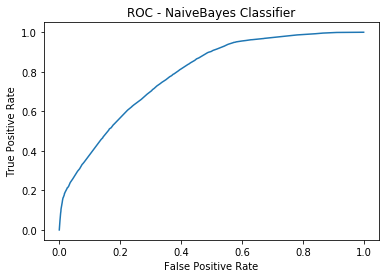

In [29]:
## NaiveBayes

from pyspark.ml.classification import NaiveBayes

start_time = time.time()

# Initialise the model
# nb = NaiveBayes(smoothing=1.0, modelType="multinomial")# Fit the model
nb = NaiveBayes()# Fit the model

paramGridnb = ParamGridBuilder()\
  .addGrid(nb.modelType, ['multinomial'])\
  .build()
#   .addGrid(nb.lambda, [1.0])\

evaluatornb = BinaryClassificationEvaluator( labelCol='label')

# // define cross validation stage to search through the parameters
# // K-Fold cross validation with BinaryClassificationEvaluator
cvnb = CrossValidator()\
  .setEvaluator(evaluatornb)\
  .setEstimatorParamMaps(paramGridnb)\
  .setNumFolds(5)\
  .setEstimator(nb)

# // fit will run cross validation and choose the best set of parameters
cvModelnb = cvnb.fit(X)

# // test cross validated model with test data
nbmodel = cvModelnb.transform(y)
# nbmodel.groupBy("label", "prediction").count().show()

print( nbmodel.groupBy("label", "prediction").count().show())

# print("Accuracy : ", evaluatornb.evaluate(nbmodel))

# Calculate the elements of the confusion matrix
#Count the number of True Negatives, True Positives, False Negatives and False Positives.
TNnb = nbmodel.filter('prediction = 0 AND label = prediction').count()
TPnb = nbmodel.filter('prediction =1 AND label = prediction').count()
FNnb = nbmodel.filter('prediction = 0 AND label != prediction').count()
FPnb = nbmodel.filter('prediction = 1 AND label != prediction').count()
 
# Accuracy measures the proportion of correct predictions
accuracy_nb = (TNnb+TPnb)/(TNnb+TPnb+FNnb+FPnb)
precision_nb = TPnb/(TPnb+FPnb)
recall_nb = TPnb/(TPnb+FNnb)
f1score_nb = 2* ( (precision_nb*recall_nb)/(precision_nb+recall_nb) )

print(accuracy_nb)
print(precision_nb)
print(recall_nb)

import matplotlib.pyplot as plt

preds_nb = cvPredictiondtc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                              float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points_nb = CurveMetrics(preds_nb).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points_nb]
y_val = [x[1] for x in points_nb]
plt.title("ROC - NaiveBayes Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 4094|
|    0|       1.0| 2701|
|    0|       0.0| 7310|
|    1|       1.0| 5868|
+-----+----------+-----+

None
0.6597907174685825
0.6847940249737425
0.589038345713712


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ROC - LogisticRegression Classifier')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

'00:01:06'

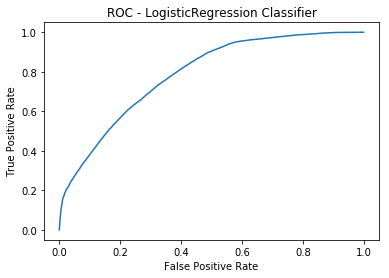

In [30]:
## Logistic Regression

from pyspark.ml.classification import LogisticRegression

start_time = time.time()

logistic = LogisticRegression() 

paramGridlr = ParamGridBuilder()\
  .addGrid(logistic.regParam, [0.1, 0.01]) \
  .build()

evaluatorlr = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')

# // define cross validation stage to search through the parameters
# // K-Fold cross validation with BinaryClassificationEvaluator
cvlr = CrossValidator()\
  .setEvaluator(evaluatorlr)\
  .setEstimatorParamMaps(paramGridlr)\
  .setNumFolds(5)\
  .setEstimator(logistic)

# // fit will run cross validation and choose the best set of parameters
cvlrModel = cvlr.fit(X)

# // test cross validated model with test data
cvPredictionlr = cvlrModel.transform(y)
print(cvPredictionlr.groupBy("label", "prediction").count().show())
# print(evaluator.evaluate(cvPredictionlr))

# Calculate the elements of the confusion matrix
#Count the number of True Negatives, True Positives, False Negatives and False Positives.
TNlr = cvPredictionlr.filter('prediction = 0 AND label = prediction').count()
TPlr = cvPredictionlr.filter('prediction =1 AND label = prediction').count()
FNlr = cvPredictionlr.filter('prediction = 0 AND label != prediction').count()
FPlr = cvPredictionlr.filter('prediction = 1 AND label != prediction').count()
 
# Accuracy measures the proportion of correct predictions
accuracy_lr = (TNlr+TPlr)/(TNlr+TPlr+FNlr+FPlr)
precision_lr = TPlr/(TPlr+FPlr)
recall_lr = TPlr/(TPlr+FNlr)
f1score_lr = 2* ( (precision_lr*recall_lr)/(precision_lr+recall_lr) )

print(accuracy_lr)
print(precision_lr)
print(recall_lr)

import matplotlib.pyplot as plt

preds_lr = cvPredictiondtc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                              float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points_lr = CurveMetrics(preds_lr).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points_lr]
y_val = [x[1] for x in points_lr]
plt.title("ROC - LogisticRegression Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1851|
|    0|       1.0| 4112|
|    0|       0.0| 5899|
|    1|       1.0| 8111|
+-----+----------+-----+

None
0.7014469533870725
0.6635850445880717
0.8141939369604497


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ROC - RandomForestClassifier')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

'00:15:34'

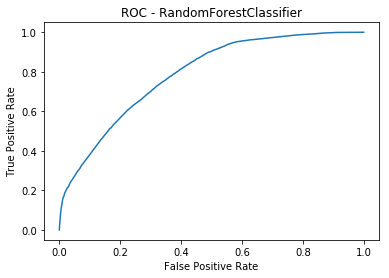

In [31]:
## Random Forest

from pyspark.ml.classification import RandomForestClassifier

start_time = time.time()

randomForestClassifier = RandomForestClassifier()
paramGrid = ParamGridBuilder()\
  .addGrid(randomForestClassifier.maxBins, [25, 28, 31])\
  .addGrid(randomForestClassifier.maxDepth, [4, 6, 8])\
  .addGrid(randomForestClassifier.impurity, ["entropy", "gini"])\
  .build()

# evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')
evaluator = BinaryClassificationEvaluator(labelCol='label')

# // define cross validation stage to search through the parameters
# // K-Fold cross validation with BinaryClassificationEvaluator
cv = CrossValidator()\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(5)\
  .setEstimator(randomForestClassifier)

# // fit will run cross validation and choose the best set of parameters
cvModel_rf = cv.fit(X)

# // test cross validated model with test data
cvPrediction_rf = cvModel_rf.transform(y)
print(cvPrediction_rf.groupBy("label", "prediction").count().show())
# evaluator.evaluate(cvPredictionDf)

# Calculate the elements of the confusion matrix
#Count the number of True Negatives, True Positives, False Negatives and False Positives.
TNrf = cvPrediction_rf.filter('prediction = 0 AND label = prediction').count()
TPrf = cvPrediction_rf.filter('prediction =1 AND label = prediction').count()
FNrf = cvPrediction_rf.filter('prediction = 0 AND label != prediction').count()
FPrf = cvPrediction_rf.filter('prediction = 1 AND label != prediction').count()
 
# Accuracy measures the proportion of correct predictions
accuracy_rf = (TNrf+TPrf)/(TNrf+TPrf+FNrf+FPrf)
precision_rf = TPrf/(TPrf+FPrf)
recall_rf = TPrf/(TPrf+FNrf)
f1score_rf = 2* ( (precision_rf*recall_rf)/(precision_rf+recall_rf) )

print(accuracy_rf)
print(precision_rf)
print(recall_rf)

import matplotlib.pyplot as plt

preds_rf = cvPredictiondtc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                              float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points_rf = CurveMetrics(preds_rf).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points_rf]
y_val = [x[1] for x in points_rf]
plt.title("ROC - RandomForestClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'ROC - Curve')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

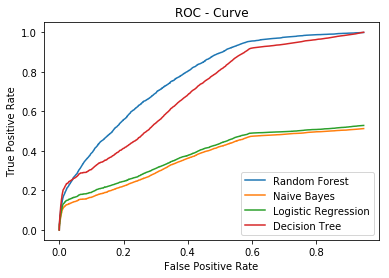

In [36]:
# Plot ROC curves
preds_rf = cvPrediction_rf.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                              float(row['label'])))
# Returns as a list (false positive rate, true positive rate)
points_rf = CurveMetrics(preds_rf).get_curve('roc')

preds_nb = nbmodel.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                      float(row['label'])))
points_nb = CurveMetrics(preds_nb).get_curve('roc')

preds_lr = cvPredictionlr.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                             float(row['label'])))
points_lr = CurveMetrics(preds_lr).get_curve('roc')

preds_dtc = cvPredictiondtc.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                               float(row['label'])))
points_dtc = CurveMetrics(preds_dtc).get_curve('roc')

# X and y must have the same first dimension with shape (N, ) per advised by the PySpark Error Message.
N=5500
plt.figure()
x_val = [x[0] for x in points_rf[0:N]]
y_val = [x[1] for x in points_rf[0:N]]
y_val_nb = [x[1] for x in points_nb[0:N]]
y_val_lr = [x[1] for x in points_lr[0:N]]
y_val_dtc = [x[1] for x in points_dtc[0:N]]
y_val_dtc = np.linspace(0,1,N)
plt.title("ROC - Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val, label='Random Forest')
plt.plot(x_val, y_val_nb, label='Naive Bayes')
plt.plot(x_val, y_val_lr, label='Logistic Regression')
plt.plot(x_val, y_val_dtc, label='Decision Tree')
plt.legend()

Text(0.5, 0, 'Threshold')

Text(0.5, 1.0, 'Precision & Recall Curves')

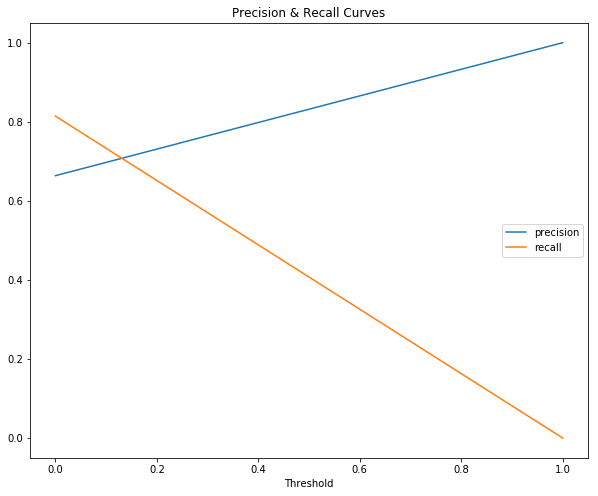

In [37]:
# TUNE THRESHOLD FOR Random Forest
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

## from sklearn metric
y_true_rf1 = cvPrediction_rf.select(['label']).collect()
y_pred_rf1 = cvPrediction_rf.select(['prediction']).collect()

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_true_rf1, y_pred_rf1)

fig = plt.figure(figsize=(10,8))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='right')
plt.xlabel('Threshold')
plt.title('Precision & Recall Curves')

In [38]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, udf

def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

ith = udf(ith_, DoubleType())

In [39]:
# curves appear to intersect at about 0.5 threshold 

import pyspark.sql.functions as  F

y_pred1 = cvPrediction_rf.select( [F.when( ith("probability", 
                                               lit(1)) >= 0.15, 1).otherwise(0).alias('prop1')] ).collect()
y_act = cvPrediction_rf.select(['label']).collect()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_act,y_pred1))
print("Accuracy: ", accuracy_score(y_act,y_pred1))

y_pred2 = cvPrediction_rf.select( [F.when( ith("probability",
                                               lit(1)) >= 0.5, 1).otherwise(0).alias('prop1')] ).collect()
print(classification_report(y_act,y_pred2))
print("Accuracy:", accuracy_score(y_act,y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.40      0.56     10011
           1       0.61      0.96      0.75      9962

   micro avg       0.68      0.68      0.68     19973
   macro avg       0.76      0.68      0.65     19973
weighted avg       0.76      0.68      0.65     19973

Accuracy:  0.6780653882741702
              precision    recall  f1-score   support

           0       0.76      0.59      0.66     10011
           1       0.66      0.81      0.73      9962

   micro avg       0.70      0.70      0.70     19973
   macro avg       0.71      0.70      0.70     19973
weighted avg       0.71      0.70      0.70     19973

Accuracy: 0.7014469533870725


In [41]:
# RANDOM FOREST INSPECTION

# List the important feature
rf_model = cvModel_rf.bestModel 
var_imp = rf_model.featureImportances
var_imp
feature_importance = pd.DataFrame(var_imp.toArray(),index = X.columns[0:5],
                                  columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importance)

SparseVector(5, {0: 0.0229, 1: 0.2223, 2: 0.0765, 3: 0.0309, 4: 0.6474})

                   Importance
day_diff             0.647402
precedent_noshows    0.222251
age                  0.076529
schedule_day         0.030930
sms                  0.022887


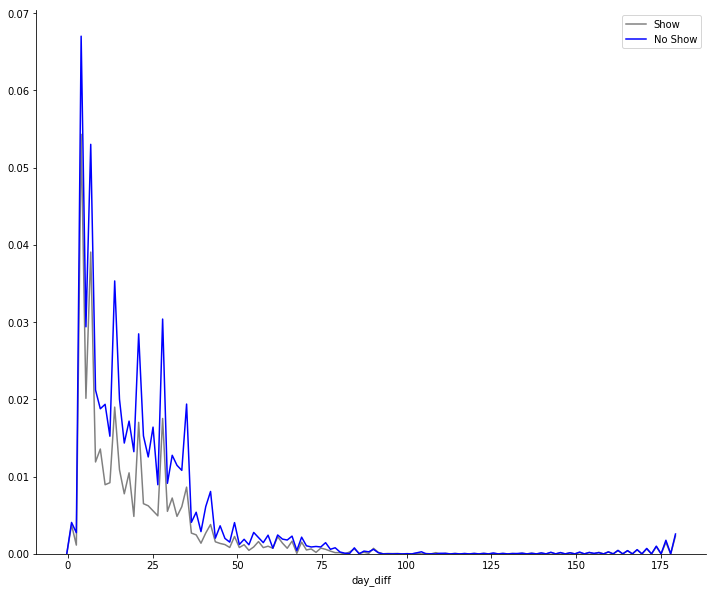

In [42]:
# Converted back to pands - only to visuvalize

df41 = df4.toPandas()

# No show = 1, show = 0
df4_noshow = df41[df41['label']==1]
df4_show = df41[df41['label']==0]

# Relationship Plots for the important features
fig = plt.figure(figsize=(12,10))
sns.distplot(df4_show["day_diff"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
sns.distplot(df4_noshow["day_diff"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
sns.despine()
plt.legend()

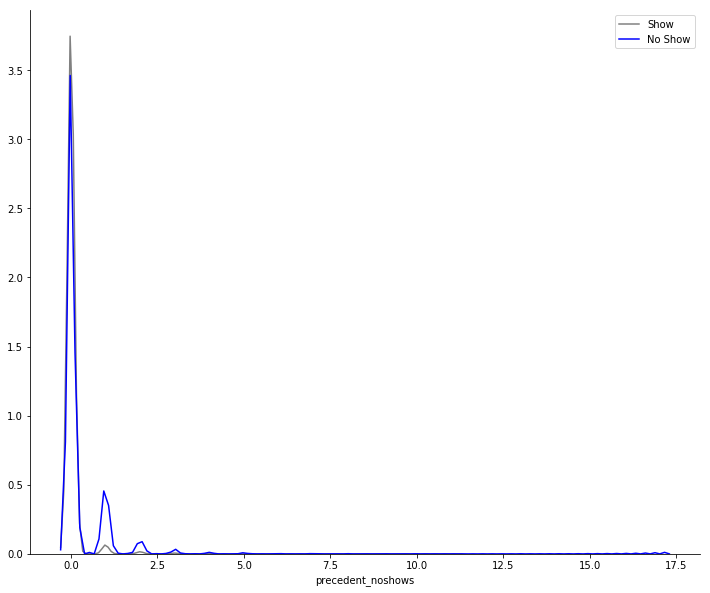

In [43]:
fig = plt.figure(figsize=(12,10))
sns.distplot(df4_show["precedent_noshows"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
sns.distplot(df4_noshow["precedent_noshows"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
sns.despine()
plt.legend()

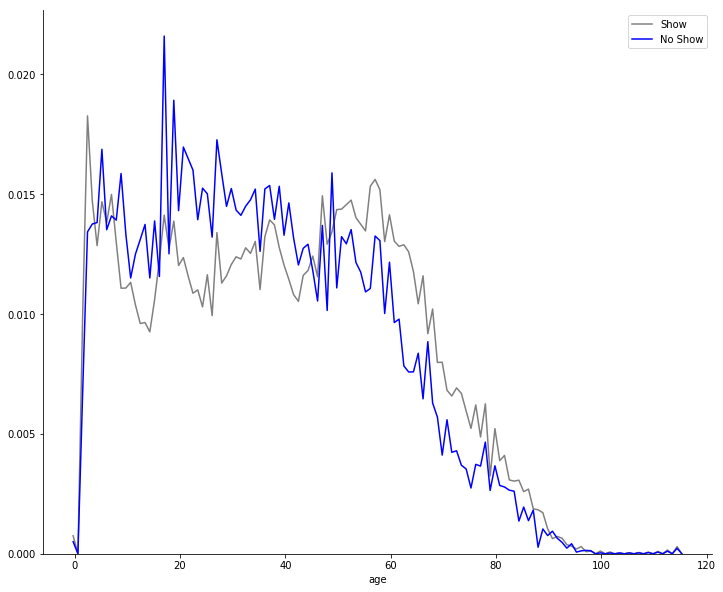

In [44]:
fig = plt.figure(figsize=(12,10))
sns.distplot(df4_show["age"], color="grey", label="Show", hist = False, kde_kws={'bw': 0.1})
sns.distplot(df4_noshow["age"], color="blue", label="No Show", hist = False, kde_kws={'bw': 0.1})
sns.despine()
plt.legend()

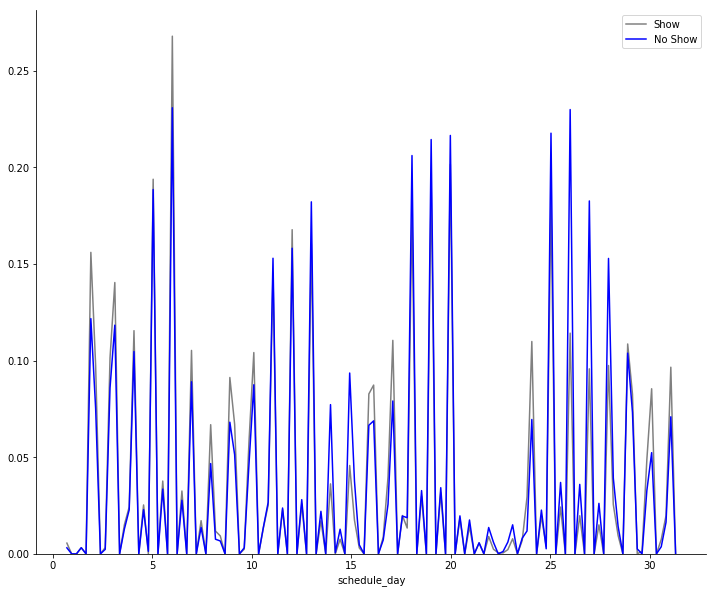

In [45]:
fig = plt.figure(figsize=(12,10))
sns.distplot(df4_show["schedule_day"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
sns.distplot(df4_noshow["schedule_day"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
sns.despine()
plt.legend()

In [46]:
#fig = plt.figure(figsize=(12,10))
#sns.distplot(df4_show["appointment_day"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
#sns.distplot(df4_noshow["appointment_day"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
#sns.despine()
#plt.legend()

In [47]:
#fig = plt.figure(figsize=(12,10))
#sns.distplot(df4_show["schedule_hour"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
#sns.distplot(df4_noshow["schedule_hour"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
#sns.despine()
#plt.legend()

In [48]:
#fig = plt.figure(figsize=(12,10))
#sns.distplot(df4_show["precedent_appointments"], color="grey", label="Show", hist=False, kde_kws={'bw': 0.1})
#sns.distplot(df4_noshow["precedent_appointments"], color="blue", label="No Show", hist=False, kde_kws={'bw': 0.1})
#sns.despine()
#plt.legend()

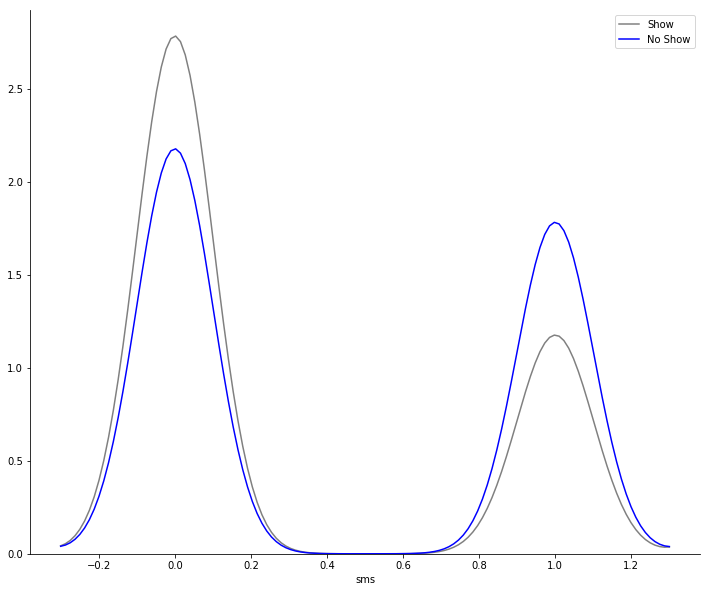

In [49]:
fig = plt.figure(figsize=(12,10))
sns.distplot(df4_show["sms"], color="grey", label="Show", hist = False, kde_kws={'bw': 0.1})
sns.distplot(df4_noshow["sms"], color="blue", label="No Show", hist = False, kde_kws={'bw': 0.1})
sns.despine()
plt.legend()

In [50]:
#fig = plt.figure(figsize=(12,10))
#sns.distplot(df4_show["hypertension"], color="grey", label="Show", hist = False, kde_kws={'bw': 0.1})
#sns.distplot(df4_noshow["hypertension"], color="blue", label="No Show", hist = False, kde_kws={'bw': 0.1})
#sns.despine()
#plt.legend()